In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

In [3]:
import pickle
from sklearn.preprocessing import RobustScaler
from recnn.preprocessing import extract, permute_by_pt

def load_test(filename):
    # Make training data
    print("Loading data...")

    fd = open(filename, "rb")
    X, y = pickle.load(fd)
    fd.close()
    indices = np.random.permutation(len(X))
    y = np.array(y)

    print("\tfilename = %s" % filename)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [extract(permute_by_pt(jet)) for jet in X]
    tf = RobustScaler().fit(np.vstack([jet["content"] for jet in X]))

    for jet in X:
        jet["content"] = tf.transform(jet["content"])
        
    # Cropping
    X_ = [j for j in X if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]
    y_ = [y[i] for i, j in enumerate(X) if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]

    X = X_
    y = y_
    
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))
        
    return X, y, tf

X, y, tf = load_test("../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27-kt")
# X, y, tf = load_test("../data/w-vs-qcd/anti-kt/antikt-delphes-test.pickle-kt")

Loading data...
	filename = ../data/w-vs-qcd/anti-kt/antikt-test.pickle-py27-kt
	X size = 20000
	y size = 20000
Preprocessing...
	X size = 7690
	y size = 7690


In [4]:
from recnn.recnn import grnn_predict_simple
from recnn.recnn import grnn_transform_simple

import pickle

fd = open("../models/delphes/w-kt-1.pickle", "rb")
# fd = open("../models/delphes/w-delphes-kt-1.pickle", "rb")
params = pickle.load(fd)
fd.close()

In [5]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y, grnn_predict_simple(params, X))

0.91236886384659421

In [8]:
fd = open("../data/w-vs-qcd/anti-kt/antikt-event-test.pickle-kt", "rb")
# fd = open("../data/w-vs-qcd/anti-kt/antikt-delphes-event-test.pickle-kt", "rb")

events = []
ys = []

for i in range(10000):
    if i % 20 == 0:
        print(i)
    e, y = pickle.load(fd)
    
    original_features = []
    jets = []
    
    for phi, eta, pt, mass, jet in e:
        original_features.append((phi, eta, pt, mass))
        jet = extract(permute_by_pt(jet))
        jet["content"] = tf.transform(jet["content"])
        jets.append(jet)
        
    events.append((np.array(original_features), jets))
    ys.append(y)
    
y = np.array(ys)
    
fd.close()

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180
4200
4

In [9]:
for l in range(10):
    scores = []
    ys = []
    
    for i in range(len(events)):
        if l < len(events[i][1]):
            scores.append(grnn_predict_simple(params, events[i][1][l:l+1])[0])
            ys.append(y[i])
    
    print(l, roc_auc_score(ys, scores))

(0, 0.89633835585353427)
(1, 0.90857467634298705)
(2, 0.74608642984345708)
(3, 0.66896612675864509)
(4, 0.60633652425346085)
(5, 0.56672620266904805)
(6, 0.53923182156927285)
(7, 0.53130392125215686)
(8, 0.52038552081542089)
(9, 0.50883842035353677)


In [10]:
scores = []

for i in range(len(events)):
    s = 0.0
    
    for l in range(5):
        s += grnn_predict_simple(params, events[i][1][l:l+1])[0]
        
    scores.append(s)
    
roc_auc_score(y, scores)

0.96623099864924011

---

In [11]:
from sklearn.preprocessing import RobustScaler
tf = RobustScaler().fit(np.vstack([features for features, _ in events]))

In [12]:
len(events)

10000

In [19]:
X = []

for features, jets in events:
    f = tf.transform(features)
    h = grnn_transform_simple(params, jets)
    X.append(np.hstack([f, h]))
    
X = [x_i[:10] for x_i in X]
X = np.array(X)
print(X.shape)

(10000, 10, 44)


In [20]:
import autograd.numpy as np
from recnn.recnn import glorot_uniform
from recnn.recnn import orthogonal
from recnn.recnn import relu
from recnn.recnn import sigmoid
from recnn.recnn import check_random_state

def vanilla_rnn_init(n_features, n_hidden, random_state=None):
    rng = check_random_state(random_state)
    return {"init_h": glorot_uniform(n_hidden, 0, rng),
            "W_h": orthogonal((n_hidden, n_hidden), rng),
            "W_x": glorot_uniform(n_hidden, n_features, rng),
            "b": np.zeros(n_hidden),
            "W_clf": [glorot_uniform(n_hidden, n_hidden, rng),
                      glorot_uniform(n_hidden, n_hidden, rng),
                      glorot_uniform(n_hidden, 0, rng)],
            "b_clf": [np.zeros(n_hidden),
                      np.zeros(n_hidden),
                      np.ones(1)]}

def vanilla_rnn_transform(params, jets):
    h = np.tile(params["init_h"], len(jets)).reshape(len(jets), -1)
    
    for t in range(jets.shape[1]):
        xt = jets[:, t, :]
        h = relu(np.dot(params["W_h"], h.T).T + np.dot(params["W_x"], xt.T).T + params["b"])

    return h

def vanilla_rnn_predict(params, jets):
    h = vanilla_rnn_transform(params, jets)

    h = relu(np.dot(params["W_clf"][0], h.T).T + params["b_clf"][0])
    h = relu(np.dot(params["W_clf"][1], h.T).T + params["b_clf"][1])
    h = sigmoid(np.dot(params["W_clf"][2], h.T).T + params["b_clf"][2])

    return h.ravel()



def gru_init(n_features, n_hidden, random_state=None):
    rng = check_random_state(random_state)
    return {"init_h": glorot_uniform(n_hidden, 0, rng),
            "W_hh": orthogonal((n_hidden, n_hidden), rng),
            "W_hx": glorot_uniform(n_hidden, n_features, rng),
            "b_h": np.zeros(n_hidden),
            "W_zh": orthogonal((n_hidden, n_hidden), rng),
            "W_zx": glorot_uniform(n_hidden, n_features, rng),
            "b_z": np.zeros(n_hidden),
            "W_rh": orthogonal((n_hidden, n_hidden), rng),
            "W_rx": glorot_uniform(n_hidden, n_features, rng),
            "b_r": np.zeros(n_hidden),
            "W_clf": [glorot_uniform(n_hidden, n_hidden, rng),
                      glorot_uniform(n_hidden, n_hidden, rng),
                      glorot_uniform(n_hidden, 0, rng)],
            "b_clf": [np.zeros(n_hidden),
                      np.zeros(n_hidden),
                      np.ones(1)]}

def gru_transform(params, jets):
    h = np.tile(params["init_h"], len(jets)).reshape(len(jets), -1)
    
    for t in range(jets.shape[1]):
        xt = jets[:, t, :]
        zt = sigmoid(np.dot(params["W_zh"], h.T).T + np.dot(params["W_zx"], xt.T).T + params["b_z"])
        rt = sigmoid(np.dot(params["W_rh"], h.T).T + np.dot(params["W_rx"], xt.T).T + params["b_r"])       
        ht = relu(np.dot(params["W_hh"], np.multiply(rt, h).T).T + np.dot(params["W_hx"], xt.T).T + params["b_h"])
        h = np.multiply(1. - zt, h) + np.multiply(zt, ht)

    return h

def gru_predict(params, jets):
    h = gru_transform(params, jets)

    h = relu(np.dot(params["W_clf"][0], h.T).T + params["b_clf"][0])
    h = relu(np.dot(params["W_clf"][1], h.T).T + params["b_clf"][1])
    h = sigmoid(np.dot(params["W_clf"][2], h.T).T + params["b_clf"][2])

    return h.ravel()

In [21]:
import copy

import autograd as ag
from recnn.recnn import log_loss
from recnn.recnn import adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=2000,
                                                      random_state=1)

init = gru_init
predict = gru_predict

n_epochs = 50
batch_size = 64
step_size = 0.0005
decay = 0.95

trained_params = init(44, 5, random_state=1)
n_batches = int(np.ceil(len(X_train) / batch_size))
best_score = [-np.inf]  # yuck, but works
best_params = [trained_params]

def loss(X, y, params):
    y_pred = predict(params, X)
    l = log_loss(y, y_pred).mean()
    return l

def objective(params, iteration):
    rng = check_random_state(iteration % n_batches)
    start = rng.randint(len(X_train) - batch_size)
    idx = slice(start, start+batch_size)
    return loss(X_train[idx], y_train[idx], params)

def callback(params, iteration, gradient):
    if iteration % 25 == 0:
        roc_auc = roc_auc_score(y_valid, predict(params, X_valid))

        if roc_auc > best_score[0]:
            best_score[0] = roc_auc
            best_params[0] = copy.deepcopy(params)

        print(
            "%5d\t~loss(train)=%.4f\tloss(valid)=%.4f"
            "\troc_auc(valid)=%.4f\tbest_roc_auc(valid)=%.4f" % (
                iteration,
                loss(X_train[:5000], y_train[:5000], params),
                loss(X_valid, y_valid, params),
                roc_auc,
                best_score[0]))

for i in range(n_epochs):
    print("epoch = %d" % i)
    print("step_size = %.4f" % step_size)

    trained_params = adam(ag.grad(objective),
                          trained_params,
                          step_size=step_size,
                          num_iters=1 * n_batches,
                          callback=callback)
    step_size = step_size * decay

epoch = 0
step_size = 0.0005
    0	~loss(train)=1.1045	loss(valid)=1.1608	roc_auc(valid)=0.4586	best_roc_auc(valid)=0.4586
   25	~loss(train)=1.0902	loss(valid)=1.1455	roc_auc(valid)=0.6154	best_roc_auc(valid)=0.6154
   50	~loss(train)=1.0562	loss(valid)=1.1089	roc_auc(valid)=0.8468	best_roc_auc(valid)=0.8468
   75	~loss(train)=0.9644	loss(valid)=1.0101	roc_auc(valid)=0.9046	best_roc_auc(valid)=0.9046
  100	~loss(train)=0.7691	loss(valid)=0.7985	roc_auc(valid)=0.9579	best_roc_auc(valid)=0.9579
epoch = 1
step_size = 0.0005
    0	~loss(train)=0.4704	loss(valid)=0.4708	roc_auc(valid)=0.9734	best_roc_auc(valid)=0.9734
   25	~loss(train)=0.3787	loss(valid)=0.3661	roc_auc(valid)=0.9784	best_roc_auc(valid)=0.9784
   50	~loss(train)=0.3423	loss(valid)=0.3246	roc_auc(valid)=0.9786	best_roc_auc(valid)=0.9786
   75	~loss(train)=0.3114	loss(valid)=0.2924	roc_auc(valid)=0.9794	best_roc_auc(valid)=0.9794
  100	~loss(train)=0.2814	loss(valid)=0.2622	roc_auc(valid)=0.9795	best_roc_auc(valid)=0.9795
ep

In [32]:
features, jets = events[5]
print(y[5])
for j in jets:
    print(j["pt"])

1
267.412839137
39.415250207
23.5980411797
21.2168321198
20.7118046871
16.7117347687
19.1275465395
17.9334322172
14.2339908259
13.613350919
13.4888093673
11.0020772977
12.8344669934
9.44970514663
7.49511069272
6.82304032534
4.56652662732
4.55178909615
4.20511455536
3.62597806086
2.83713767679
2.89979446348
2.79273584374
2.68638084093
2.54697387992
2.52295906405
2.14501939776
1.98560288337
1.76643438865
1.76915223772
1.46660150246
1.38870984055
1.24643686425
0.892840041959
0.867205290703
0.710562603467
0.614620043501
0.54687411684
0.473092426327
0.405385085637
0.402666616646
0.311493311602
0.229915034303
0.104200466638
0.102050561206
0.0564801816809
0.0257452279404


In [37]:
for i in range(10):
    print(i, roc_auc_score(y, [-jets[i]["pt"] for _, jets in events]))

(0, 0.56420626256825046)
(1, 0.96776727871069124)
(2, 0.83230303329212141)
(3, 0.7687326307493052)
(4, 0.71567674862706998)
(5, 0.66643188665727549)
(6, 0.63598322543932906)
(7, 0.61117750444710017)
(8, 0.59528634381145373)
(9, 0.58424578336983135)


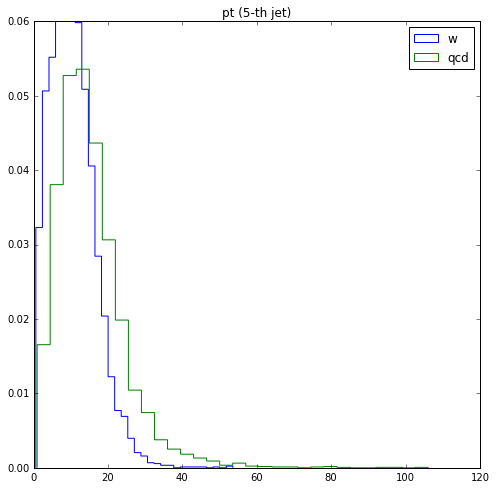

In [60]:
n = 5
plt.hist([jets[n]["pt"] for i, (f, jets) in enumerate(events) if y[i] == 1], 
         histtype="step", bins=30, normed=1, label="w")
plt.hist([jets[n]["pt"] for i, (f, jets) in enumerate(events) if y[i] == 0], 
         histtype="step", bins=30, normed=1, label="qcd")
plt.legend(loc="best")
plt.title("pt (%d-th jet)" % n)
plt.show()